In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e04_liver.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e13_orig.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e11_liver.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e05_orig.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e10_orig.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e09_orig.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e02_liver.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e13_liver.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e12_liver.nii
/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset/ircad_e19_orig.nii
/kaggle/input/ircadresearch-institu

In [21]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


In [22]:
!pip install nibabel

In [23]:
import os
import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm


In [24]:
DATA_ROOT = "/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset"
OUT_ROOT  = "/kaggle/working/processed"

IMG_DIR   = f"{OUT_ROOT}/images"
LIVER_DIR = f"{OUT_ROOT}/masks/liver"

TARGET_SIZE = (256, 256)


In [25]:
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LIVER_DIR, exist_ok=True)

Utility functions

In [26]:
def preprocess_ct(img):
    img = np.clip(img, -100, 400)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return cv2.resize(img, TARGET_SIZE).astype(np.float32)

In [27]:
def preprocess_mask(mask):
    mask = (mask > 0).astype(np.uint8)
    return cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)


In [28]:
#loading one patient pair
def load_pair(orig_path, liver_path):
    ct = nib.load(orig_path).get_fdata()
    liver = nib.load(liver_path).get_fdata()
    return ct, liver
    TARGET_SIZE = (256,256)

In [29]:
def preprocess_ct_slice(img):
    # Windowing (paper-inspired)
    img = np.clip(img, -100, 400)

    # Normalize to [0, 1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Resize
    img = cv2.resize(img, TARGET_SIZE)

    return img.astype(np.float32)


In [30]:
def preprocess_mask_slice(mask):
    # Binary mask
    mask = (mask > 0).astype(np.uint8)

    # Resize (IMPORTANT: nearest, not linear)
    mask = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

    return mask


In [31]:
def process_case(case_id, orig_path, liver_path,
                 img_out_dir, mask_out_dir):

    ct_vol, liver_vol = load_pair(orig_path, liver_path)

    os.makedirs(f"{img_out_dir}/{case_id}", exist_ok=True)
    os.makedirs(f"{mask_out_dir}/{case_id}", exist_ok=True)

    num_slices = ct_vol.shape[2]

    for i in range(num_slices):
        ct_slice = preprocess_ct_slice(ct_vol[:, :, i])
        liver_slice = preprocess_mask_slice(liver_vol[:, :, i])

        np.save(f"{img_out_dir}/{case_id}/slice_{i:03d}.npy", ct_slice)
        np.save(f"{mask_out_dir}/{case_id}/slice_{i:03d}.npy", liver_slice)


In [32]:
DATA_ROOT = "/kaggle/input/ircadresearch-institute-against-digestive-cancer/ircad-dataset"
OUT_ROOT  = "/kaggle/working/processed"

IMG_DIR   = f"{OUT_ROOT}/images"
LIVER_DIR = f"{OUT_ROOT}/masks/liver"

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LIVER_DIR, exist_ok=True)


In [33]:
orig_files = sorted([f for f in os.listdir(DATA_ROOT) if f.endswith("_orig.nii")])

print("Number of cases:", len(orig_files))


Number of cases: 20


In [35]:
for f in tqdm(orig_files):
    case_id = f.replace("_orig.nii", "")
    liver_file = f.replace("_orig.nii", "_liver.nii")

    process_case(
        case_id,
        os.path.join(DATA_ROOT, f),
        os.path.join(DATA_ROOT, liver_file),
        IMG_DIR,
        LIVER_DIR
    )

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


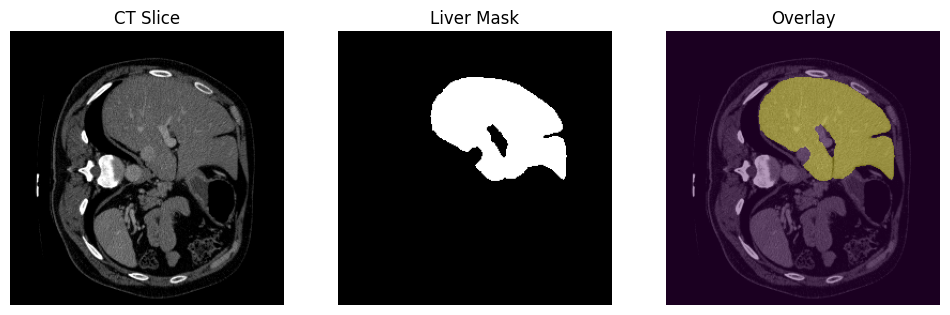

In [37]:
import matplotlib.pyplot as plt
import random
import numpy as np
import os

case = random.choice(os.listdir(IMG_DIR))
slice_file = random.choice(os.listdir(f"{IMG_DIR}/{case}"))

img = np.load(f"{IMG_DIR}/{case}/{slice_file}")
mask = np.load(f"{LIVER_DIR}/{case}/{slice_file}")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("CT Slice")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Liver Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img, cmap="gray")
plt.imshow(mask, alpha=0.4)
plt.axis("off")

plt.show()

In [38]:
import torch
from torch.utils.data import Dataset

In [39]:
class LiverDataset(Dataset):
    def __init__(self, img_root, mask_root):
        self.samples = []

        for case in os.listdir(img_root):
            img_dir = os.path.join(img_root, case)
            mask_dir = os.path.join(mask_root, case)

            for f in os.listdir(img_dir):
                self.samples.append((
                    os.path.join(img_dir, f),
                    os.path.join(mask_dir, f)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = np.load(img_path)
        mask = np.load(mask_path)

        # add channel dim (paper uses single-channel CT)
        img = torch.from_numpy(img).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return img, mask.float()


In [40]:
from torch.utils.data import DataLoader

dataset = LiverDataset(IMG_DIR, LIVER_DIR)

train_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Total training slices:", len(dataset))


Total training slices: 2823


In [42]:
import torch
import torch.nn as nn

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch)
        )

        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return torch.relu(self.conv(x) + self.skip(x))


In [45]:
class ResUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = ResidualBlock(1, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResidualBlock(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(128, 64)

        # Output
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.out(d1))


In [46]:
#dice loss
def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return 1 - dice

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = ResUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [48]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        loss = dice_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/25] - Loss: 0.2351
Epoch [2/25] - Loss: 0.0661
Epoch [3/25] - Loss: 0.0483
Epoch [4/25] - Loss: 0.0457
Epoch [5/25] - Loss: 0.0420
Epoch [6/25] - Loss: 0.0394
Epoch [7/25] - Loss: 0.0331
Epoch [8/25] - Loss: 0.0365
Epoch [9/25] - Loss: 0.0318
Epoch [10/25] - Loss: 0.0268
Epoch [11/25] - Loss: 0.0255
Epoch [12/25] - Loss: 0.0366
Epoch [13/25] - Loss: 0.0250
Epoch [14/25] - Loss: 0.0239
Epoch [15/25] - Loss: 0.0242
Epoch [16/25] - Loss: 0.0250
Epoch [17/25] - Loss: 0.0241
Epoch [18/25] - Loss: 0.0210
Epoch [19/25] - Loss: 0.0231
Epoch [20/25] - Loss: 0.0186
Epoch [21/25] - Loss: 0.0178
Epoch [22/25] - Loss: 0.0189
Epoch [23/25] - Loss: 0.0171
Epoch [24/25] - Loss: 0.0166
Epoch [25/25] - Loss: 0.0183


In [50]:
torch.save(model.state_dict(), "resunet_liver_latest.pth")

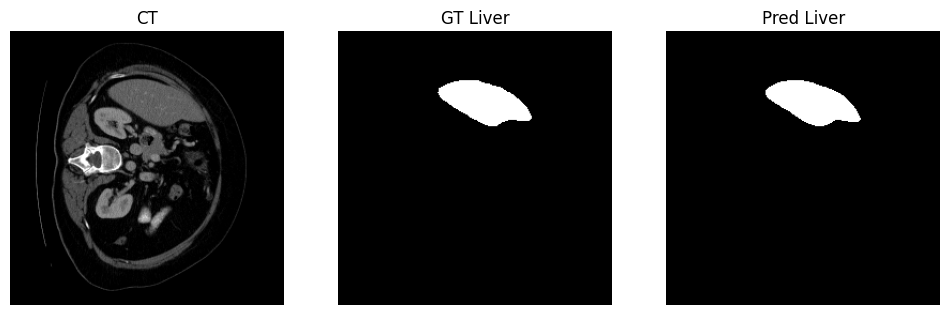

In [53]:
import random
import matplotlib.pyplot as plt

model.eval()

imgs, masks = next(iter(train_loader))
imgs = imgs.to(device)

with torch.no_grad():
    preds = model(imgs)

idx = random.randint(0, imgs.size(0)-1)

img  = imgs[idx, 0].cpu().numpy()
gt   = masks[idx, 0].cpu().numpy()
pred = (preds[idx, 0].cpu().numpy() > 0.5).astype(int)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("CT"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("GT Liver"); plt.imshow(gt, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Pred Liver"); plt.imshow(pred, cmap="gray"); plt.axis("off")
plt.show()

In [55]:
def dice_score(pred, target, smooth=1.0):
    pred = (pred > 0.5).float()
    pred = pred.view(-1)
    target = target.view(-1)
    return (2*(pred*target).sum()+smooth)/(pred.sum()+target.sum()+smooth)


In [56]:
model.eval()
dice_scores = []

with torch.no_grad():
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        preds = model(imgs)
        dice_scores.append(dice_score(preds, masks).item())

print("Mean Dice:", sum(dice_scores)/len(dice_scores))


Mean Dice: 0.9781575425826119
